In [29]:
# --+ loading libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
#import geoplot as gplt
import statsmodels.tsa.stattools as stattools
import math
import plotly.graph_objects as go
from shapely.geometry import Point
from plotly.subplots import make_subplots
from plotly.offline import *
from plotly.offline import iplot
import os

In [30]:
# creating variable for the path to read the CSVs
files = os.listdir('CSVs')

# looking what files are located into the file path
# print(files)

# creation of dicitonaries to store the df
dataframes = {}

# reading each CSV file
for file in files:
    if file.endswith('.csv'):
        file_path = os.path.join('CSVs', file)
        df = pd.read_csv(file_path)
        dataframes[file.replace('.csv', '')] = df

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_63239/1306352509.py:14: DtypeWarning:

Columns (41,42,43,44,45,46,47,48,49,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_63239/1306352509.py:14: DtypeWarning:

Columns (7,17,18,21,22,24,25,29,32,39,47) have mixed types. Specify dtype option on import or set low_memory=False.



In [31]:
data = dataframes['BasicCompanyDataAsOneFile-2021-12-01']
postcodes = dataframes['postcodes']

In [32]:
# TODO - this method is being used when the csv files exist in the same directory with the python file
# data = pd.read_csv('BasicCompanyDataAsOneFile-2021-12-01.csv')
# postcodes = pd.read_csv('postcodes.csv')

Pre-processing and data cleaning

In [33]:
# dropping unncessary columns
data = data.drop([
    'RegAddress.CareOf', 'RegAddress.POBox', 'RegAddress.County',
    'DissolutionDate', 'PreviousName_1.CONDATE', ' PreviousName_1.CompanyName',
    ' PreviousName_2.CONDATE', ' PreviousName_2.CompanyName',
    'PreviousName_3.CONDATE', ' PreviousName_3.CompanyName',
    'PreviousName_4.CONDATE', ' PreviousName_4.CompanyName',
    'PreviousName_5.CONDATE', ' PreviousName_5.CompanyName',
    'PreviousName_6.CONDATE', ' PreviousName_6.CompanyName',
    'PreviousName_7.CONDATE', ' PreviousName_7.CompanyName',
    'PreviousName_8.CONDATE', ' PreviousName_8.CompanyName',
    'PreviousName_9.CONDATE', ' PreviousName_9.CompanyName',
    'PreviousName_10.CONDATE', ' PreviousName_10.CompanyName',
    'ConfStmtNextDueDate', ' ConfStmtLastMadeUpDate',
    'Mortgages.NumMortOutstanding', 'Mortgages.NumMortPartSatisfied',
    'Mortgages.NumMortSatisfied', 'SICCode.SicText_2', 'SICCode.SicText_3',
    'SICCode.SicText_4', 'LimitedPartnerships.NumGenPartners',
    'LimitedPartnerships.NumLimPartners'
],
                 axis=1)

In [34]:
# keeping only England companies
data = data[(data["RegAddress.Country"] == "ENGLAND")]

In [35]:
# --+ dropping NA
data = data.dropna(subset=['SICCode.SicText_1'])

In [36]:
# removing dormant companies
data = data[data["SICCode.SicText_1"] != "99999 - Dormant Company"]

In [37]:
# removing none supplied option
data = data[data["SICCode.SicText_1"] != "None Supplied"]

In [38]:
# keeping only the first digits of the SIC code (2 digits)
data = data.loc[data["SICCode.SicText_1"].notnull()]

In [39]:
data.loc[:, "2digSIC"] = data["SICCode.SicText_1"].str[0:2]

In [40]:
# general sum of the SIC codes of every company
data["Number_of_SIC"] = 4 - (data[["SICCode.SicText_1"]].isnull().sum(axis=1))

In [41]:
# changing the astype of our column
Sic1 = data['2digSIC'].to_numpy()
Sic1 = Sic1.astype(str).astype(int)
data['Sic2DigNum'] = Sic1

In [42]:
def SICtoIndustry(SICCode):
    if SICCode in [i for i in range(1, 4)]:
        SICCode = "Agriculture, Forestry and Fishing"
    elif SICCode in [i for i in range(5, 10)]:
        SICCode = "Mining and Quarrying"
    elif SICCode in [i for i in range(10, 34)]:
        SICCode = "Manufacturing"
    elif SICCode == 35:
        SICCode = "Electricity, gas, steam and air conditioning supply"
    elif SICCode in [i for i in range(36, 40)]:
        SICCode = "Water supply, sewerage, waste management and remediation activities"
    elif SICCode in [i for i in range(41, 44)]:
        SICCode = "Construction"
    elif SICCode in [i for i in range(45, 48)]:
        SICCode = "Wholesale and retail trade; repair of motor vehicles and motorcycles"
    elif SICCode in [i for i in range(49, 54)]:
        SICCode = "Transportation and storage"
    elif SICCode in [i for i in range(55, 57)]:
        SICCode = "Accommodation and food service activities"
    elif SICCode in [i for i in range(58, 64)]:
        SICCode = "Information and communication"
    elif SICCode in [i for i in range(64, 67)]:
        SICCode = "Financial and insurance activities"
    elif SICCode == 68:
        SICCode = "Real estate activities"
    elif SICCode in [i for i in range(69, 76)]:
        SICCode = "Professional, scientific and technical activities"
    elif SICCode in [i for i in range(77, 83)]:
        SICCode = "Administrative and support service activities"
    elif SICCode == 84:
        SICCode = "Public administration and defence; compulsory social security"
    elif SICCode == 85:
        SICCode = "Education"
    elif SICCode in [i for i in range(86, 89)]:
        SICCode = "Human health and social work activities"
    elif SICCode in [i for i in range(90, 94)]:
        SICCode = "Arts, entertainment and recreation"
    elif SICCode in [i for i in range(94, 97)]:
        SICCode = "Other service activities"
    elif SICCode in [i for i in range(97, 99)]:
        SICCode = "Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use"
    elif SICCode == 99:
        SICCode = "Activities of extraterritorial organisations and bodies"
    else:
        SICCode = np.NAN
    return SICCode

In [43]:
# --+ applying the function
data["SIC_1_Industry"] = data["Sic2DigNum"].apply(SICtoIndustry)

In [44]:
# london dataset
london = data[((data["RegAddress.PostTown"] == "GREATER LONDON") |
               (data["RegAddress.PostTown"] == "LONDON"))]

In [45]:
# --+ dropping NA
london = london.dropna(subset=['SICCode.SicText_1'])

In [46]:
# removing dormant companies
london = london[london["SICCode.SicText_1"] != "99999 - Dormant Company"]

In [47]:
# removing none supplied option
london = london[london["SICCode.SicText_1"] != "None Supplied"]

In [48]:
# keeping only the first digits of the SIC code (2 digits)
london = london.loc[london["SICCode.SicText_1"].notnull()]

In [49]:
london.loc[:, "2digSIC"] = london["SICCode.SicText_1"].str[0:2]

In [50]:
# general sum of the SIC codes of every company
london["Number_of_SIC"] = 4-(london[["SICCode.SicText_1"]].isnull().sum(axis=1))

In [51]:
# changing the astype of our column
Sic1 = london['2digSIC'].to_numpy()
Sic1 = Sic1.astype(str).astype(int)
london['Sic2DigNum'] = Sic1

In [52]:
# --+ applying the function
london["SIC_1_Industry"] = london["Sic2DigNum"].apply(SICtoIndustry)

In [53]:
# --+ transforming date
london['IncorporationDate'] = pd.to_datetime(london['IncorporationDate'], 
                                             format='%d/%m/%Y', errors = 'coerce')

In [54]:
# --+ adding new column year
london["IncorporationYear"] = london["IncorporationDate"].apply(lambda x: str(x.year))

In [55]:
# --+ keeping companies since 2019
london = london[london.IncorporationYear >= "2019"]

In [56]:
london = london.drop([
    'Mortgages.NumMortCharges', 'URI', 'Returns.LastMadeUpDate',
    'Returns.NextDueDate', 'Accounts.AccountCategory',
    'Accounts.LastMadeUpDate', 'Accounts.NextDueDate',
    'Accounts.AccountRefMonth', 'Accounts.AccountRefDay', 'CompanyStatus',
    'CompanyCategory'
],
                     axis=1)

In [57]:
# --+ transforming date
data['IncorporationDate'] = pd.to_datetime(data['IncorporationDate'], 
                                           format='%d/%m/%Y', errors='coerce')

In [58]:
# --+ adding new column year
data["IncorporationYear"] = data["IncorporationDate"].apply(
    lambda x: str(x.year))

In [59]:
# --+ adding new column month-year
data["IncorporationMonth"] = data["IncorporationDate"].apply(lambda x: str(
    x.year)) + "-" + data["IncorporationDate"].apply(lambda x: str(x.month))

In [60]:
# --+ keeping companies since 2019
data = data[data.IncorporationDate >= "01/01/2019"]

In [61]:
# --+ Pre-covid data, first national lockdown took place at 23th March 2020
pre_covid_london = london[london.IncorporationDate < pd.to_datetime("23/03/2020", format='%d/%m/%Y')]

In [62]:
# --+ after lockdown data
covid_london = london[london.IncorporationDate >= pd.to_datetime("23/03/2020", format='%d/%m/%Y')]

In [63]:
# --+ preparing new dataset based on the postcodes.csv file
x = data.copy()
y = postcodes[[
    'Postcode', 'County', 'Country', 'Latitude', 'Longitude', 'London zone'
]]

In [64]:
# --+ combining the two CSVs
combined_df = pd.merge(x,
                       y,
                       how='left',
                       left_on='RegAddress.PostCode',
                       right_on='Postcode')

In [65]:
# --+ creating a new data csv file
combined_df = combined_df[~combined_df["Country"].isnull()]
combined_df = combined_df[(combined_df['Latitude'] != 0)
                          & (combined_df['Longitude'] != 0)]
combined_df.drop(columns=["RegAddress.PostCode"], inplace=True)
combined_df.to_csv('cleaned_data.csv', index=False)

In [66]:
# --+ getting geometry points
points = []
for lon, lat in zip(combined_df["Longitude"], combined_df["Latitude"]):
    points.append(Point(lon, lat))

In [67]:
# --+ adding new column
combined_df["geometry"] = points

In [68]:
# --+ geodataframe
combined_df = gpd.GeoDataFrame(combined_df)

Pre-processing for every different Industry

In [69]:
combined_df.head(5)

CompanyName  CompanyNumber RegAddress.AddressLine1  \
0                      !GOBERUB LTD       13404790      30 MAZE GREEN ROAD   
1                   !T DROP LIMITED       13563692     INTERNATIONAL HOUSE   
2                    " BORA " 2 LTD       13220580     26 CARMICHAEL CLOSE   
3    " TRIPLE D" PROPERTIES LIMITED       13310195        66 MORRIS STREET   
4  "24/7" UK CUSTOMS AGENTS LIMITED       12792142  OFFICE 221 CEME CAMPUS   

   RegAddress.AddressLine2 RegAddress.PostTown RegAddress.Country  \
0                      NaN  BISHOP'S STORTFORD            ENGLAND   
1        PARK STREET SOUTH       WOLVERHAMPTON            ENGLAND   
2        WINSTANLEY ESTATE              LONDON            ENGLAND   
3                      NaN       WEST BROMWICH            ENGLAND   
4                MARSH WAY             RAINHAM            ENGLAND   

                                     CompanyCategory CompanyStatus  \
0                            Private Limited Company        Active   
1                            Private Limited Company        Active   
2  PRI/LTD BY GUAR/NSC (Private, limited by guara...        Active   
3                            Private Limited Company        Active   
4                            Private Limited Company        Active   

  CountryOfOrigin IncorporationDate  ...  \
0  United Kingdom        2021-05-17  ...   
1  United Kingdom        2021-08-12  ...   
2  United Kingdom        2021-02-23  ...   
3  United Kingdom        2021-04-01  ...   
4  United Kingdom        2020-08-04  ...   

                                      SIC_1_Industry  IncorporationYear  \
0                      Information and communication               2021   
1                      Information and communication               2021   
2  Wholesale and retail trade; repair of motor ve...               2021   
3                             Real estate activities               2021   
4                         Transportation and storage               2020   

  IncorporationMonth  Postcode          County  Country   Latitude  Longitude  \
0             2021-5  CM23 2PJ   Hertfordshire  England  51.871917   0.147103   
1             2021-8   WV2 3JH   West Midlands  England  52.571432  -2.129644   
2             2021-2  SW11 2HS  Greater London  England  51.465268  -0.175649   
3             2021-4   B70 7SP   West Midlands  England  52.511598  -1.997378   
4             2020-8  RM13 8EU  Greater London  England  51.517691   0.171971   

  London zone                   geometry  
0         NaN   POINT (0.14710 51.87192)  
1         NaN  POINT (-2.12964 52.57143)  
2         2.0  POINT (-0.17565 51.46527)  
3         NaN  POINT (-1.99738 52.51160)  
4         6.0   POINT (0.17197 51.51769)  

[5 rows x 33 columns]

In [70]:
# creating a DataFrame with value counts and reset the index
NumberOfCompaniesSameIndustry = pd.DataFrame(
    combined_df['SIC_1_Industry'].value_counts().reset_index()
)

# renaming the columns to make it more meaningful
NumberOfCompaniesSameIndustry.columns = ['SIC_1_Industry', 'count']

# converting the 'count' column to numeric
NumberOfCompaniesSameIndustry['count'] = pd.to_numeric(NumberOfCompaniesSameIndustry['count'], errors='coerce')

In [71]:
# --+ smaller Industries
smallerIndustries = NumberOfCompaniesSameIndustry.sort_values(
    by=['SIC_1_Industry']).head(5)

In [72]:
# --+ largest Industries
biggestIndustries = NumberOfCompaniesSameIndustry.nlargest(5, 'count')

In [73]:
# --+ dataframe with smallest Industries regarding the number of opening
df_small = combined_df[(
    (combined_df["SIC_1_Industry"]
     == 'Public administration and defence; compulsory social security') |
    (combined_df["SIC_1_Industry"]
     == "Water supply, sewerage, waste management and remediation activities")
    | (combined_df["SIC_1_Industry"]
       == 'Electricity, gas, steam and air conditioning supply') |
    (combined_df["SIC_1_Industry"] == 'Mining and Quarrying') |
    (combined_df["SIC_1_Industry"]
     == 'Activities of extraterritorial organisations and bodies'))]

In [74]:
# --+ dataframe largest Industries
df_large = combined_df[(
    (combined_df["SIC_1_Industry"]
     == 'Wholesale and retail trade; repair of motor vehicles and motorcycles')
    | (combined_df["SIC_1_Industry"] == "Construction") |
    (combined_df["SIC_1_Industry"]
     == 'Professional, scientific and technical activities') |
    (combined_df["SIC_1_Industry"] == 'Real estate activities') |
    (combined_df["SIC_1_Industry"] == 'Information and communication'))]

In [75]:
# --+ grouping by SIC_1_Industry and IncorporationYear LARGE
df_large_year = df_large.groupby(['SIC_1_Industry',
                                  'IncorporationYear']).count()
df_large_year.reset_index(inplace=True)

In [76]:
# --+ grouping by SIC_1_Industry and IncorporationMonth LARGE
df_large_month = df_large.groupby(['SIC_1_Industry',
                                   'IncorporationMonth']).count()
df_large_month.reset_index(inplace=True)

In [77]:
# --+ grouping by SIC_1_Industry and IncorporationYear SMALL
df_small_year = df_small.groupby(['SIC_1_Industry',
                                  'IncorporationYear']).count()
df_small_year.reset_index(inplace=True)

In [78]:
# --+ grouping by SIC_1_Industry and IncorporationMonth SMALL
df_small_month = df_small.groupby(['SIC_1_Industry',
                                   'IncorporationMonth']).count()
df_small_month.reset_index(inplace=True)

In [79]:
# --+ df small companies necessary columns
smallindustries = df_small_month[[
    'SIC_1_Industry', 'IncorporationMonth', 'CompanyName'
]]

In [80]:
# --+ converting datetime for small industries
smallindustries.loc[:, 'IncorporationMonth'] = pd.to_datetime(
    smallindustries['IncorporationMonth'], errors='coerce')

In [81]:
# --+ sorting by month and year
smallindustries = smallindustries.sort_values(by=['IncorporationMonth'])

In [82]:
# --+ largeindustries dataframe
largeindustries = df_large_month[[
    'SIC_1_Industry', 'IncorporationMonth', 'CompanyName'
]]

In [83]:
# --+ converting datetime for large industries
largeindustries.loc[:, 'IncorporationMonth'] = pd.to_datetime(
    largeindustries['IncorporationMonth'], errors='coerce')

In [84]:
# --+ sorting by month and year
largeindustries = largeindustries.sort_values(by=['IncorporationMonth'])

Continue to pre-processing for 2nd and 3rd graph

In [85]:
# --+ LONDON DATASET FOR PLOT SPECIFIC SECTORS
df_london = london[(
    (london["SIC_1_Industry"]
     == 'Wholesale and retail trade; repair of motor vehicles and motorcycles')
    | (london["SIC_1_Industry"] == "Construction") |
    (london["SIC_1_Industry"]
     == 'Professional, scientific and technical activities') |
    (london["SIC_1_Industry"] == 'Real estate activities') |
    (london["SIC_1_Industry"] == 'Information and communication'))]

In [86]:
# --+ grouping by SIC_1_Industry and IncorporationYear LARGE
df_london_year = df_london.groupby(['SIC_1_Industry',
                                    'IncorporationYear']).count()
df_london_year.reset_index(inplace=True)

In [87]:
# --+ large industries dataframe
london_for_use = df_london_year[[
    'SIC_1_Industry', 'IncorporationYear', 'CompanyName'
]]

In [88]:
# Calculating Percentage
london_for_use.loc[:, 'percent'] = (london_for_use['CompanyName'] /
                                    london_for_use['CompanyName'].sum()) * 100

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_63239/2433138420.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
# --+ graph 3 cleaning datasets
graph3_df = combined_df.drop([
    'RegAddress.AddressLine1', 'RegAddress.PostTown', 'CompanyStatus',
    'IncorporationDate', 'Accounts.AccountRefDay', 'Accounts.AccountRefMonth',
    'Accounts.LastMadeUpDate', 'Accounts.AccountCategory',
    'Returns.LastMadeUpDate', 'Mortgages.NumMortCharges', 'SICCode.SicText_1',
    'URI', 'Number_of_SIC', 'IncorporationMonth', 'London zone'
],
                             axis=1)

In [90]:
# --+ keeping companies since 2019
graph3_df = graph3_df[graph3_df.IncorporationYear >= "2019"]

In [91]:
# --+ focusing on one specific sector
graph3_df = graph3_df[graph3_df.SIC_1_Industry == "Real estate activities"]

# 1st Graph
### Line graph comparing the number of companies opening before and after the lockdowns

In [92]:
# --+ pre-processing before plotting

# renaming columns for consistency & clarification

smallindustries = smallindustries.rename(columns={'CompanyName': 'Number of Companies'})
largeindustries = largeindustries.rename(columns={'CompanyName': 'Number of Companies'})

smallindustries = smallindustries.rename(columns={'SIC_1_Industry': 'Industry/Sector'})
largeindustries = largeindustries.rename(columns={'SIC_1_Industry': 'Industry/Sector'})

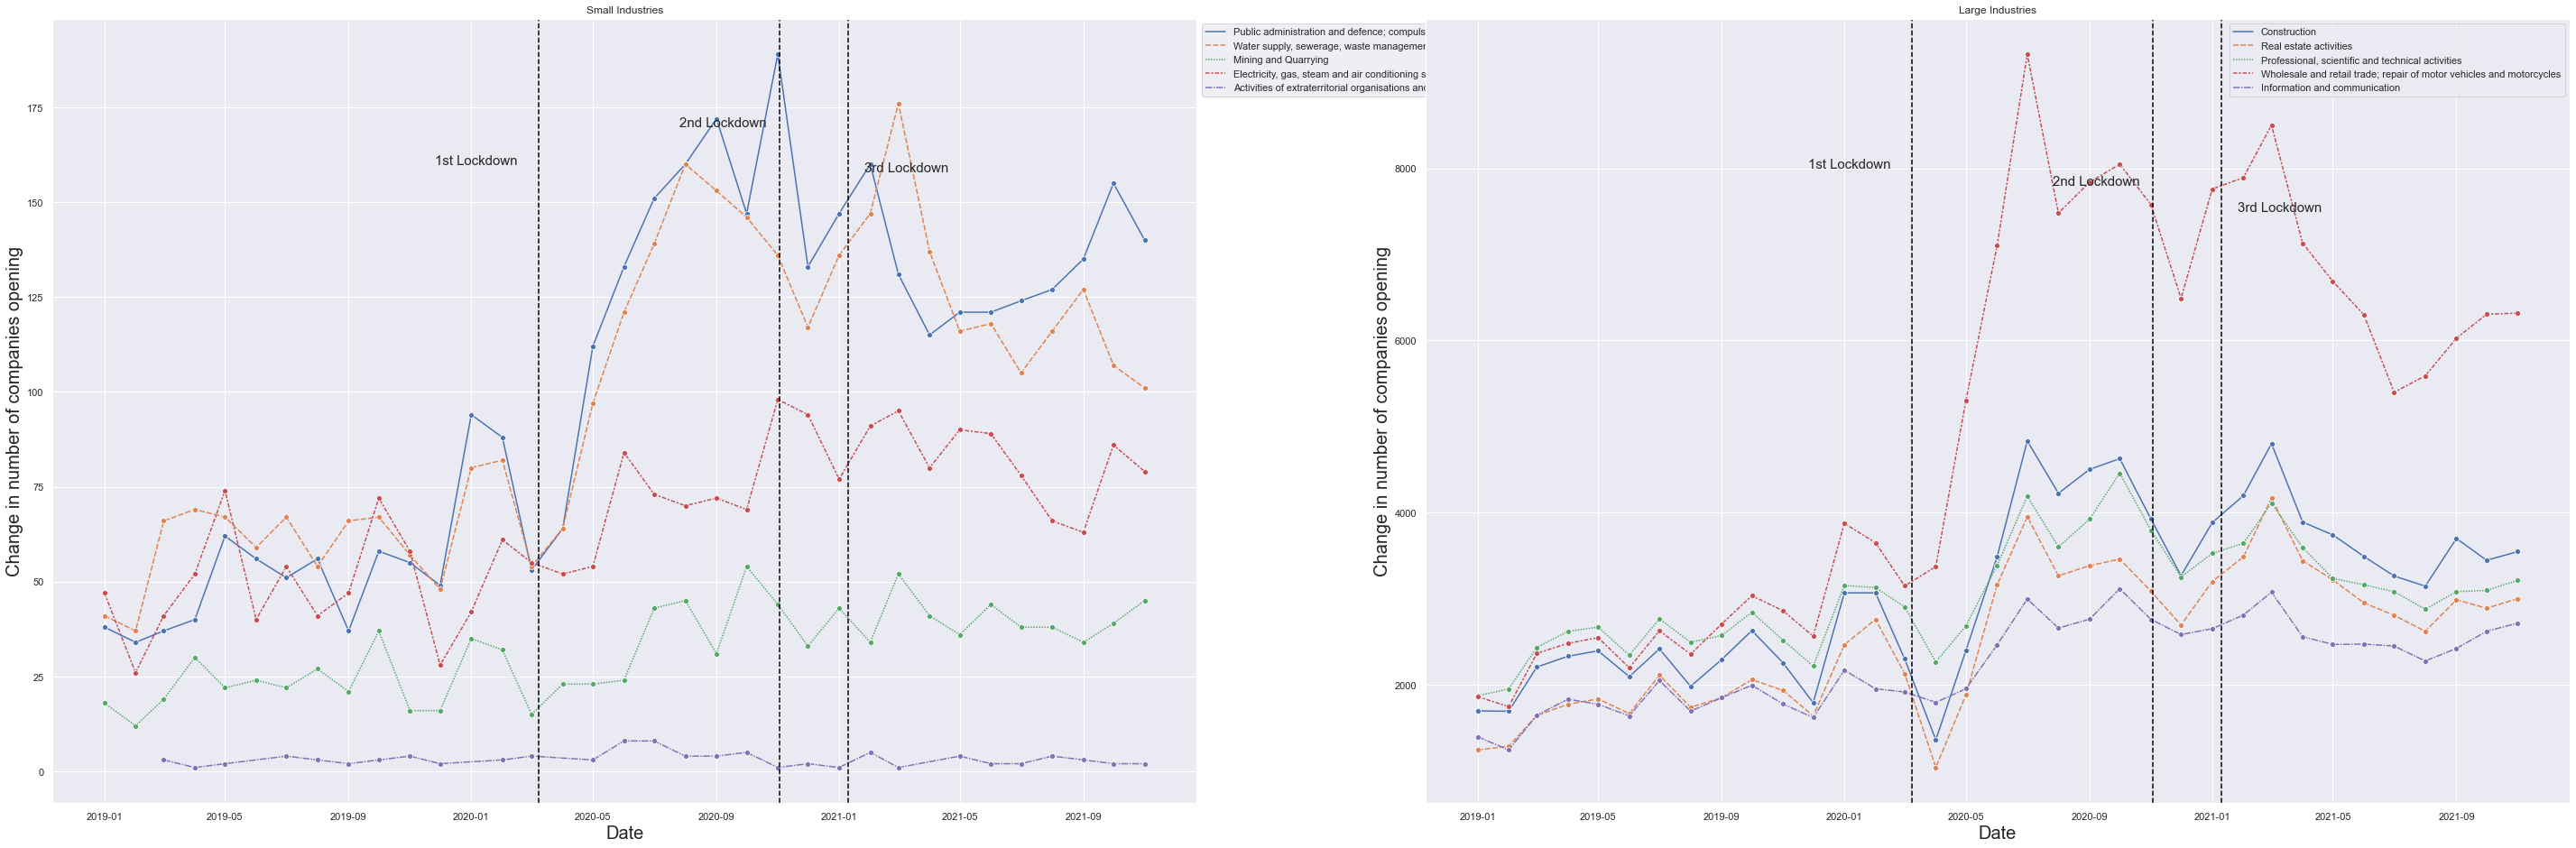

In [93]:
sns.set(rc={'figure.figsize': (50, 16)})
ax = plt.subplot(1, 2, 1)
ax1 = plt.subplot(1, 2, 2)

z = sns.lineplot(data=smallindustries,
                 x='IncorporationMonth',
                 y='Number of Companies',
                 hue='Industry/Sector',
                 style='Industry/Sector',
                 marker="o",
                 ax = ax)
z.axvline(pd.to_datetime('2020-03-08'), color='black', linestyle='--')
z.annotate('1st Lockdown',
           xy=((pd.to_datetime('2019-11-26')), 160),
           fontsize=15)
z.axvline(pd.to_datetime('2020-11-03'), color='black', linestyle='--')
z.annotate('2nd Lockdown',
           xy=((pd.to_datetime('2020-07-26')), 170),
           fontsize=15)
z.axvline(pd.to_datetime('2021-01-10'), color='black', linestyle='--')
z.annotate('3rd Lockdown',
           xy=((pd.to_datetime('2021-01-26')), 158),
           fontsize=15)
z.legend(bbox_to_anchor=(1.0, 1), loc='best')
z.set_title('Small Industries')
z.set_xlabel("Date", fontsize=20)
z.set_ylabel("Change in number of companies opening", fontsize=20)

p = sns.lineplot(data=largeindustries,
                 x='IncorporationMonth',
                 y='Number of Companies',
                 hue='Industry/Sector',
                 style='Industry/Sector',
                 marker="o",
                 ax = ax1)
p.axvline(pd.to_datetime('2020-03-08'), color='black', linestyle='--')
p.annotate('1st Lockdown',
           xy=((pd.to_datetime('2019-11-26')), 8000),
           fontsize=15)
p.axvline(pd.to_datetime('2020-11-03'), color='black', linestyle='--')
p.annotate('2nd Lockdown',
           xy=((pd.to_datetime('2020-07-26')), 7800),
           fontsize=15)
p.axvline(pd.to_datetime('2021-01-10'), color='black', linestyle='--')
p.annotate('3rd Lockdown',
           xy=((pd.to_datetime('2021-01-26')), 7500),
           fontsize=15)
p.legend(bbox_to_anchor=(1.0, 1), loc='best')
p.set_title('Large Industries')
p.set_xlabel("Date", fontsize=20)
p.set_ylabel("Change in number of companies opening", fontsize=20)

plt.show()

## Line graph using plotly with smoother lines

In [94]:
# creating line plot for small industries

fig = px.line(smallindustries, x='IncorporationMonth', y='Number of Companies',
              color='Industry/Sector', line_shape='spline',
              markers=True, title='Small Industries')

# adding vertical lines for lockdowns

fig.add_vline(x='2020-03-08', line_dash='dash', line_color='black', name='1st Lockdown')
fig.add_annotation(x='2020-01-10', y=160, text='1st Lockdown', showarrow=False)

fig.add_vline(x='2020-11-03', line_dash='dash', line_color='black', name='2nd Lockdown')
fig.add_annotation(x='2020-09-26', y=175, text='2nd Lockdown', showarrow=False)

fig.add_vline(x='2021-01-10', line_dash='dash', line_color='black', name='3rd Lockdown')
fig.add_annotation(x='2021-02-26', y=182, text='3rd Lockdown', showarrow=False)


# updating layout

fig.update_layout(xaxis_title='Date',
                  yaxis_title='Change in number of companies opening',
                  legend_title='Industry',
                  height=800, width=2000)

# creating line plot for large industries
fig1 = px.line(largeindustries, x='IncorporationMonth', y='Number of Companies',
               color='Industry/Sector', line_shape='spline',
               markers=True, title='Large Industries')


# adding vertical lines for lockdowns

fig1.add_vline(x='2020-03-08', line_dash='dash', line_color='black', name='1st Lockdown')
fig1.add_annotation(x='2020-01-10', y=8000, text='1st Lockdown', showarrow=False)

fig1.add_vline(x='2020-11-03', line_dash='dash', line_color='black', name='2nd Lockdown')
fig1.add_annotation(x='2020-09-26', y=8800, text='2nd Lockdown', showarrow=False)

fig1.add_vline(x='2021-01-10', line_dash='dash', line_color='black', name='3rd Lockdown')
fig1.add_annotation(x='2021-02-26', y=6800, text='3rd Lockdown', showarrow=False)


# updating layout

fig1.update_layout(xaxis_title='Date',
                   yaxis_title='Change in number of companies opening',
                   legend_title='Industry',
                   height=800, width=2000)

# displaying the plots

fig.show()
fig1.show()

# 2nd Graph
Bar chart from London largest industries | and the difference of increase/decrease in new corporations from 2019-2021

In [99]:
labels = [
    'Construction', 'Information and communication', 'Professional activities',
    'Real estate', 'Wholesale and retail'
]
values19 = [4264, 6403, 7195, 4654, 6979]
values20 = [7445, 10301, 11041, 7825, 18335]
values21 = [7537, 10739, 10606, 9503, 20569]

c = []
i = 0

while i < len(values19):
    if values19[i] > values20[i]:
        q = values19[i] - values20[i]
        c.append('-' + str(math.floor(q / values19[i] * 100)) + '%')
    elif values19[i] < values20[i]:
        t = values20[i] - values19[i]
        c.append('+' + str(math.floor(t / values19[i] * 100)) + '%')
    else:
        c.append('0%')
    i += 1

c1 = []
j = 0

while j < len(values20):
    if values20[j] > values21[j]:
        q = values20[j] - values21[j]
        c1.append('-' + str(math.floor(q / values20[j] * 100)) + '%')
    elif values20[j] < values21[j]:
        t = values21[j] - values20[j]
        c1.append('+' + str(math.floor(t / values20[j] * 100)) + '%')
    else:
        c1.append('0%')
    j += 1

# creating bar plots
trace1 = go.Bar(x=labels, y=values19, name='2019')
trace2 = go.Bar(x=labels, y=values20, name='2020', text=c)
trace3 = go.Bar(x=labels, y=values21, name='2021', text=c1)

# creating line graph
line_trace = go.Scatter(x=labels, y=values21, name='Trend', mode='lines+markers')

# defining data and layout for both plots
data = [trace1, trace2, trace3, line_trace]
layout = go.Layout(
    barmode='group',
    title='New Incorporations in London',
)

# creating figure and add both plots
fig = go.Figure(data=data, layout=layout)

# ploting the figure
iplot(fig)

# saving the figure as an HTML file
# fig.write_html('New Incorporations in London.html')

3rd Graph 
New Incorporations in a 3 year span (2019-2021) of 'Real estate activities' in the UK 

In [96]:
fig = px.scatter_mapbox(graph3_df,
                        lat='Latitude',
                        lon='Longitude',
                        opacity=0.25,
                        center=dict(lat=52.64, lon=-1.13),
                        zoom=5,
                        color='IncorporationYear',
                        mapbox_style="open-street-map",
                        title="Real estate activities",
                        width=800,
                        height=800)

fig.show()
# fig.write_html('Real estate activities the past three years.html')

In [97]:
labels = [
    'Construction', 'Information and communication', 'Professional activities',
    'Real estate', 'Wholesale and retail'
]
values18 = [4264, 6403, 7195, 4654, 6979]
values19 = [7445, 10301, 11041, 7825, 18335]
values20 = [7537, 10739, 10606, 9503, 20569]
values21 = [7639, 10957, 10498, 9882, 21447]

# creating a df
df = pd.DataFrame({
    'Year': [2018, 2019, 2020, 2021] * len(labels),
    'Label': labels * 4,
    'Value': values18 + values19 + values20 + values21,
})

# calculating the size for the bubbles
df['Size'] = df.groupby('Label')['Value'].pct_change().abs() * 100
# Fill NaN values with a default size (e.g., 10)
df['Size'] = df['Size'].fillna(10)

# creating interactive bubble chart with plotly express
fig = px.scatter(
    df,
    x='Label', y='Value',
    size='Size', color='Label',
    animation_frame='Year',
    title='New Incorporations in London (Interactive Bubble Chart)',
    labels={'Value': 'Number of Incorporations', 'Label': 'Industry'},
    size_max=50,
)

# updating layout to display month names on x-axis
fig.update_layout(
    xaxis=dict(title='Industry'),
    yaxis=dict(title='Number of Incorporations'),
)

# saving the figure as an HTML file
# fig.write_html('New Incorporations Interactive Bubble Chart.html')

# displaying the figure
fig.show()

In [98]:
# from bokeh.plotting import figure, curdoc
# from bokeh.models import ColumnDataSource, HoverTool, Slider
# from bokeh.layouts import layout

# # Your existing data
# labels = [
#     'Construction', 'Information and communication', 'Professional activities',
#     'Real estate', 'Wholesale and retail'
# ]
# values18 = [4264, 6403, 7195, 4654, 6979]
# values19 = [7445, 10301, 11041, 7825, 18335]
# values20 = [7537, 10739, 10606, 9503, 20569]
# values21 = [7639, 10957, 10498, 9882, 21447]

# # Creating a DataFrame
# df = pd.DataFrame({
#     'Year': [2018, 2019, 2020, 2021] * len(labels),
#     'Label': labels * 4,
#     'Value': values18 + values19 + values20 + values21,
# })

# # Calculating the size for the bubbles
# df['Size'] = df.groupby('Label')['Value'].pct_change().abs() * 100
# # Fill NaN values with a default size (e.g., 10)
# df['Size'] = df['Size'].fillna(10)

# # Create ColumnDataSource
# source = ColumnDataSource(df)

# # Set up plot
# p = figure(title='New Incorporations in London (Animated Bubble Chart)',
#            x_range=labels, y_range=(0, max(df['Value']) * 1.2),
#            plot_height=400, plot_width=800, toolbar_location=None)

# # Add scatter plot
# p.scatter(x='Label', y='Value', size='Size', color='Label', source=source, legend_field='Label')

# # Add hover tool
# hover = HoverTool()
# hover.tooltips = [('Year', '@Year'), ('Value', '@Value')]
# p.add_tools(hover)

# # Set up slider
# slider = Slider(start=df['Year'].min(), end=df['Year'].max(), value=df['Year'].min(), step=1, title='Year')

# # Define callback function for slider
# def update(attrname, old, new):
#     year = slider.value
#     new_data = df[df['Year'] == year]
#     source.data = ColumnDataSource.from_df(new_data)

# # Attach callback to slider
# slider.on_change('value', update)

# # Set up layout
# layout = layout([[p], [slider]])

# # Display the plot
# curdoc().add_root(layout)